## Análise e modelagem para previsão da temperatura de transição vítrea (Tg) a partir de estruturas simplificadas (SMILES)

---



# 1. Carregar e Inspecionar os Dados









In [ ]:
#Baixando e verificando o dataset
!pip install kagglehub

import kagglehub
import pandas as pd
import os

# Download latest version of the dataset
path = kagglehub.dataset_download("linyeping/extra-dataset-with-smilestgpidpolimers-class")

print("Path to dataset files:", path)

# List files in the directory to find the CSV file
files = os.listdir(path)
csv_files = [f for f in files if f.endswith('.csv')]

if not csv_files:
    raise FileNotFoundError("No CSV files found in the dataset directory.")

# Assume that the first CSV file found is the correct one
dataset_path = os.path.join(path, csv_files[0])

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(dataset_path)

print("\nDataset loaded successfully.")

# Display the first 5 rows of the DataFrame
print("Primeiras 5 linhas do DataFrame:")
display(df.head())

# Display information about the DataFrame (column names, data types, non-null values)
print("\nInformações do DataFrame:")
display(df.info())

# Display descriptive statistics of the DataFrame
print("\nEstatísticas descritivas do DataFrame:")
display(df.describe())

# Verificar a quantidade de dados faltantes por coluna
print("\nQuantidade de dados faltantes por coluna:")
display(df.isnull().sum())

100%|██████████| 107k/107k [00:00<00:00, 412kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/linyeping/extra-dataset-with-smilestgpidpolimers-class/versions/1

Dataset loaded successfully.
Primeiras 5 linhas do DataFrame:


,SMILES,Tg,PID,Polymer Class
0,*C*,-54.0,P010001,Polyolefins
1,*CC(*)C,-3.0,P010002,Polyolefins
2,*CC(*)CC,-24.1,P010003,Polyolefins
3,*CC(*)CCC,-37.0,P010004,Polyolefins
4,*CC(*)C(C)C,60.0,P010006,Polyolefins



Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7284 entries, 0 to 7283
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SMILES         7284 non-null   object 
 1   Tg             7284 non-null   float64
 2   PID            7284 non-null   object 
 3   Polymer Class  7284 non-null   object 
dtypes: float64(1), object(3)
memory usage: 227.8+ KB


None


Estatísticas descritivas do DataFrame:


,Tg
count,7284.000000
mean,140.190628
std,112.961182
min,-139.000000
25%,53.112500
50%,132.000000
75%,230.000000
max,495.000000



Quantidade de dados faltantes por coluna:


,0
SMILES,0
Tg,0
PID,0
Polymer Class,0


# 2. Análise Exploratória dos Dados

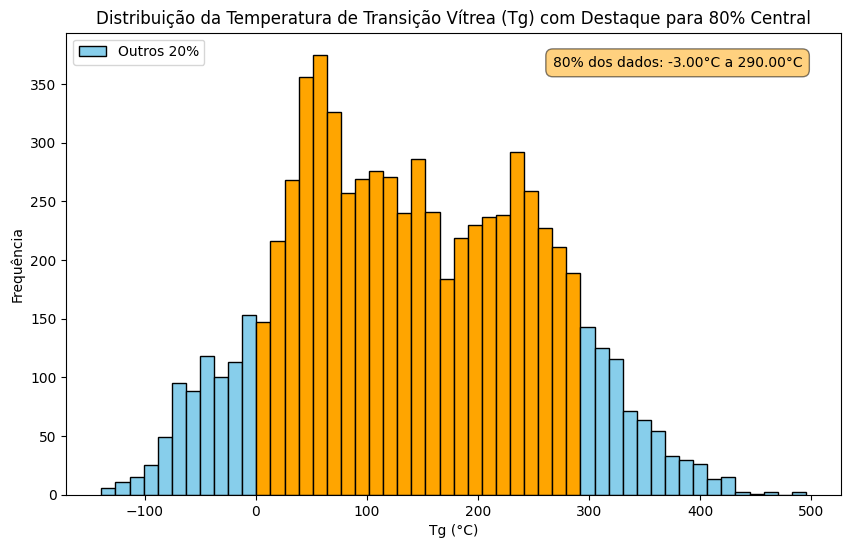


Gerando histogramas para classes de polímeros com 300 ou mais representantes:


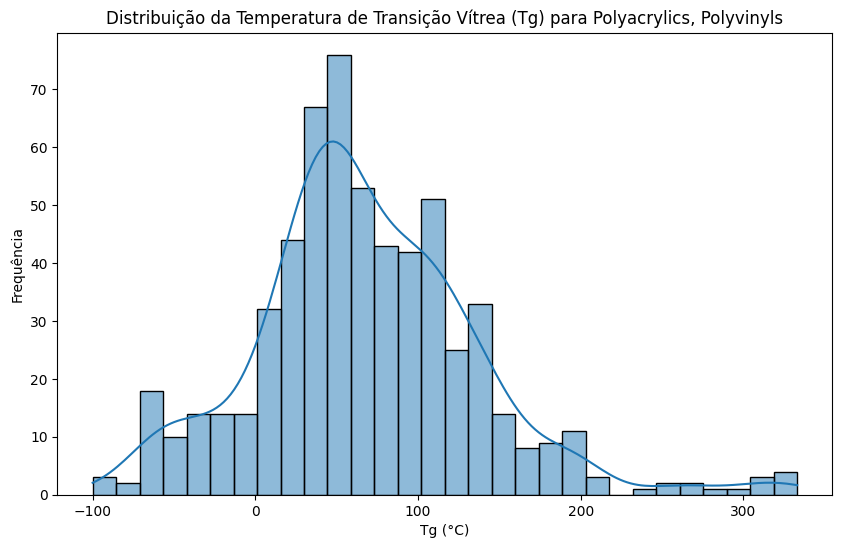

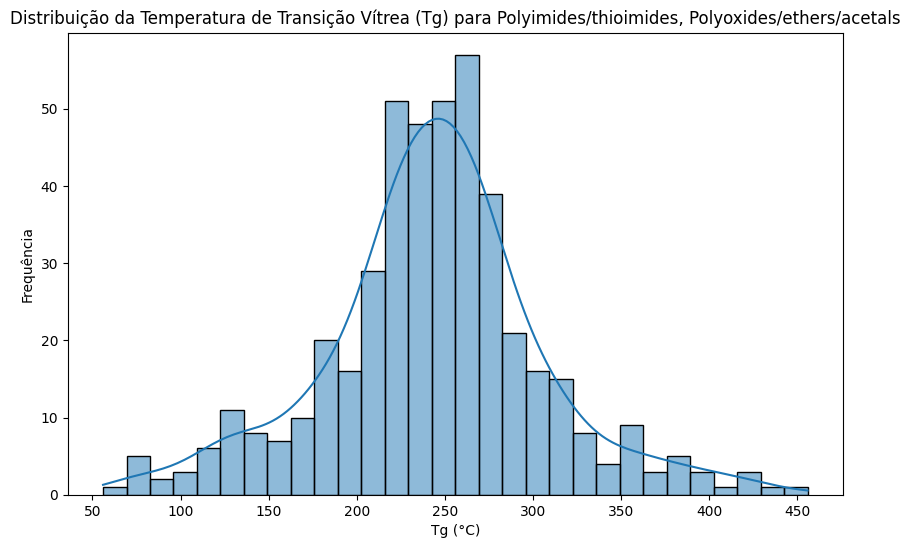

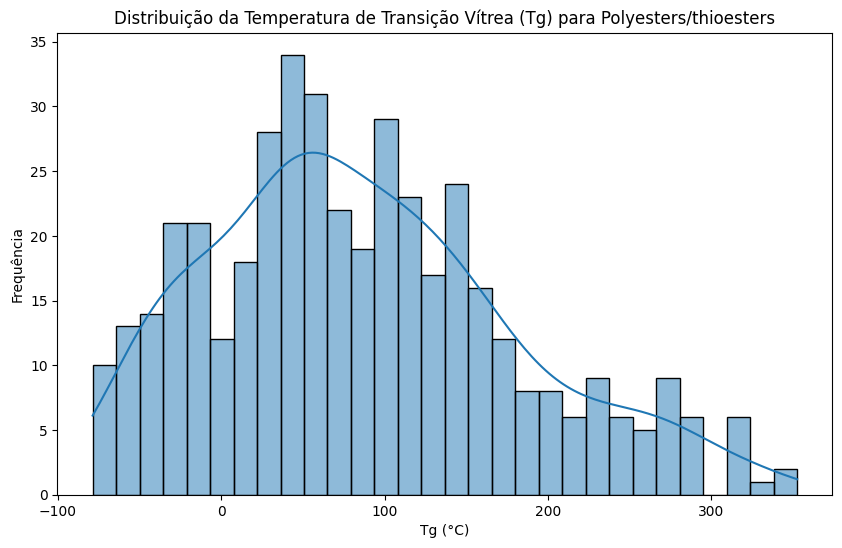

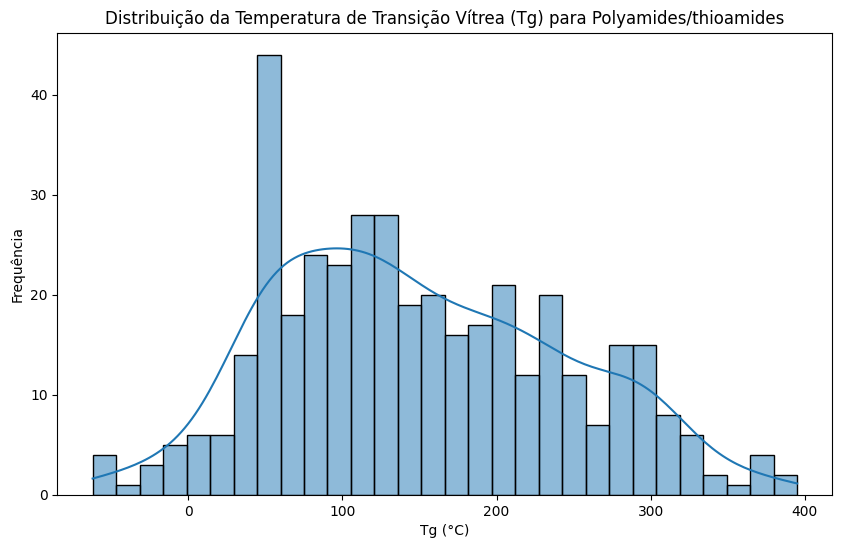

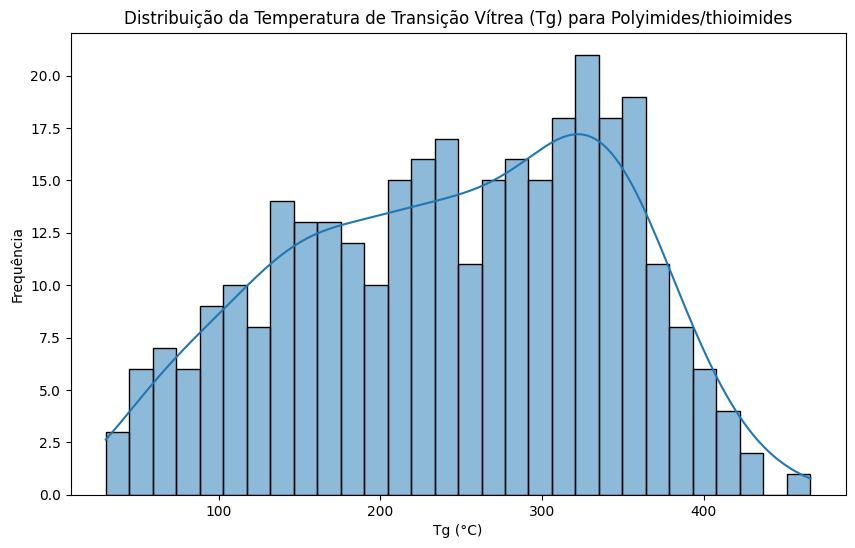

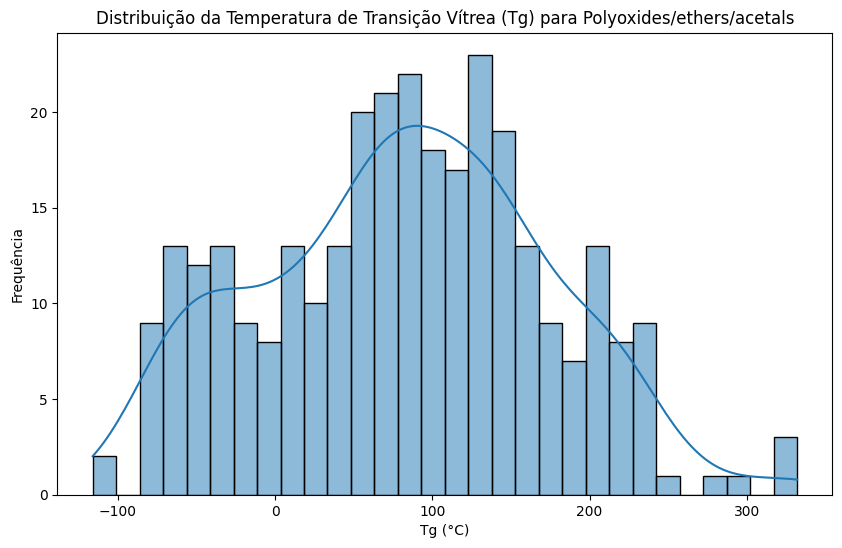

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualizar a distribuição da variável 'Tg'
plt.figure(figsize=(10, 6))

# Calculate percentiles for the central 80%
lower_bound = df['Tg'].quantile(0.10)
upper_bound = df['Tg'].quantile(0.90)

# Create the histogram
n, bins, patches = plt.hist(df['Tg'], bins=50, edgecolor='black', label='Outros 20%') # Use bins=50 or adjust as needed

# Color the bars based on the percentile range and add labels for legend
for patch, bin_edge in zip(patches, bins[:-1]):
    if lower_bound <= bin_edge < upper_bound:
        patch.set_facecolor('orange') # Color for the central 80%
        # We need a way to add a single label for the orange bars in the legend.
        # A common approach is to create a proxy artist or add a dummy plot.
        # For simplicity here, we'll add text annotations instead of a formal legend item for the range.
    else:
        patch.set_facecolor('skyblue') # Color for the outer 20%


plt.title('Distribuição da Temperatura de Transição Vítrea (Tg) com Destaque para 80% Central')
plt.xlabel('Tg (°C)')
plt.ylabel('Frequência')

# Add text annotations for the 80% range and its bounds
plt.text(0.95, 0.95, f'80% dos dados: {lower_bound:.2f}°C a {upper_bound:.2f}°C',
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round,pad=0.5', fc='orange', alpha=0.5))

# Add a legend for the 'Outros 20%' label added to the hist call
plt.legend()

plt.show()


# --- Plotagens individuais por classe de polímeros (se houverem mais de 300 representantes) ---

# Contar a frequência de cada Polymer Class
polymer_class_counts = df['Polymer Class'].value_counts()

# Filtrar as classes com pelo menos 300 representantes
major_polymer_classes = polymer_class_counts[polymer_class_counts >= 300].index.tolist()

print("\nGerando histogramas para classes de polímeros com 300 ou mais representantes:")

# Gerar histogramas para cada classe principal
for polymer_class in major_polymer_classes:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df[df['Polymer Class'] == polymer_class], x='Tg', bins=30, kde=True, edgecolor='black')
    plt.title(f'Distribuição da Temperatura de Transição Vítrea (Tg) para {polymer_class}')
    plt.xlabel('Tg (°C)')
    plt.ylabel('Frequência')
    plt.show()



# 3. Pré-processamento das Features

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#Transformando as variáveis textuais em códigos binários

# Identificar colunas categóricas para one-hot encoding
categorical_features = ['Polymer Class']
# Identificar colunas a serem removidas antes do pré-processamento inicial
columns_to_drop_before_processing = ['SMILES', 'PID']

# Separar as features (X) e a variável alvo (y)
X = df.drop('Tg', axis=1)
y = df['Tg']

# Remover colunas que não serão processadas ou que serão tratadas separadamente (SMILES, PID)
X_processed_initial = X.drop(columns=columns_to_drop_before_processing)


# Criar o ColumnTransformer para aplicar one-hot encoding apenas nas colunas categóricas restantes
# 'remainder='passthrough'' manterá outras colunas numéricas se houver (neste caso, não há)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Manter outras colunas numéricas
)

# Aplicar o pré-processamento no conjunto completo de features (sem SMILES e PID)
X_processed_cat = preprocessor.fit_transform(X_processed_initial)

# Converter o resultado do OneHotEncoder (array numpy) de volta para DataFrame
# Isso ajuda a manter os nomes das colunas para a junção posterior com descritores
# Nota: Obter nomes de colunas exatos após OneHotEncoder com handle_unknown='ignore' pode ser complexo.
# Para simplificar, vamos usar nomes genéricos temporariamente ou tentar obter os nomes.
# Uma abordagem mais robusta para nomes de colunas pode ser necessária em fluxos de trabalho mais complexos.
# Por enquanto, manteremos como array numpy e lidaremos com a junção com descritores depois.

print("One-hot encoding aplicado na coluna 'Polymer Class' usando OneHotEncoder.")
print(f"Formato de X_processed_cat (após one-hot encoding): {X_processed_cat.shape}")

# Manter o X original (com SMILES e PID) para o cálculo de descritores na próxima etapa
# X já foi definido no início desta célula

One-hot encoding aplicado na coluna 'Polymer Class' usando OneHotEncoder.
Formato de X_processed_cat (após one-hot encoding): (7284, 198)


# 3.2 Cálculo de descritores moleculares a partir de Smiles

In [ ]:
#Convertendo strings Smiles em features numéricas usando o RDKit

# Instalar RDKit se ainda não estiver instalado
!pip install rdkit

from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd # Importar pandas novamente caso a célula anterior tenha sido executada isoladamente

# Certifique-se de que a coluna 'SMILES' existe no DataFrame original X
if 'SMILES' in X.columns:
    # Função para converter SMILES em objeto molécula RDKit
    def smiles_to_mol(smiles_string):
        try:
            mol = Chem.MolFromSmiles(smiles_string)
            return mol
        except:
            # print(f"Could not parse SMILES: {smiles_string}") # Opcional: imprimir SMILES inválidos
            return None

    # Aplicar a função para criar uma nova coluna com objetos molécula no DataFrame X
    X['Molecule'] = X['SMILES'].apply(smiles_to_mol)

    # Remover linhas onde a conversão falhou (SMILES inválido) do DataFrame X
    # É importante manter o índice original para a junção posterior
    X_valid = X.dropna(subset=['Molecule']).copy()

    # Calcular alguns descritores moleculares básicos para as moléculas válidas
    def calculate_descriptors(mol):
        if mol is not None:
            # Exemplo de descritores: Peso Molecular, LogP, Contagem de Ligações Rotacionáveis
            mw = Descriptors.MolWt(mol)
            logp = Descriptors.MolLogP(mol)
            rb = Descriptors.NumRotatableBonds(mol)
            return pd.Series({'MolecularWeight': mw, 'LogP': logp, 'RotatableBonds': rb})
        return pd.Series({'MolecularWeight': None, 'LogP': None, 'RotatableBonds': None})

    # Aplicar a função para calcular descritores nas moléculas válidas
    molecular_descriptors = X_valid['Molecule'].apply(calculate_descriptors)

    # molecular_descriptors agora contém os descritores para as linhas válidas de X

    print("Descritores moleculares calculados.")
    print("\nPrimeiras 5 linhas do DataFrame de descritores:")
    display(molecular_descriptors.head())

else:
    print("Coluna 'SMILES' não encontrada no DataFrame X.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 23.9 MB/s eta 0:00:00
Descritores moleculares calculados.

Primeiras 5 linhas do DataFrame de descritores:


,MolecularWeight,LogP,RotatableBonds
0,14.027,0.4608,0.0
1,42.081,1.3117,1.0
2,56.108,1.7018,2.0
3,70.135,2.0919,3.0
4,70.135,1.9478,2.0


# 4. Divisão dos Dados e Junção de Features

In [ ]:
#Separação dos dados para treino e teste
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# X_processed_cat contains the one-hot encoded categorical features (as numpy array)
# molecular_descriptors contains the molecular descriptors (as DataFrame) for the valid rows

# We need to ensure that the descriptor and one-hot encoded feature sets
# correspond to the same rows of the original DataFrame (handling invalid SMILES)

# First, filter X and y to match the valid indices after SMILES processing
# The 'Molecule' column was added to X in a previous step (ae3717ba)
# We need to make sure X_valid is available from that step
if 'X_valid' not in locals():
    # Re-create X_valid if the previous cell wasn't run or the variable was cleared
    if 'df' in locals() and 'SMILES' in df.columns:
        X = df.drop('Tg', axis=1).copy() # Create X if not exists
        def smiles_to_mol(smiles_string):
            try:
                mol = Chem.MolFromSmiles(smiles_string)
                return mol
            except:
                return None
        X['Molecule'] = X['SMILES'].apply(smiles_to_mol)
        X_valid = X.dropna(subset=['Molecule']).copy()
        y_valid = df.loc[X_valid.index, 'Tg'] # Get corresponding y for valid rows
    else:
        raise ValueError("DataFrame 'df' or 'SMILES' column not found. Please run the initial data loading and SMILES processing cells.")
else:
     # If X_valid exists, make sure y_valid also exists and matches
     if 'y_valid' not in locals() or not y_valid.index.equals(X_valid.index):
          if 'df' in locals():
               y_valid = df.loc[X_valid.index, 'Tg']
          else:
               raise ValueError("DataFrame 'df' not found to create 'y_valid'.")


# Separate features (X) and target (y) for the valid rows
X_valid_features = X_valid.copy() # Work on a copy to avoid SettingWithCopyWarning
# y_valid is already defined above

# Remove columns that will not be processed or that are treated separately (SMILES, PID, Molecule)
# Explicitly drop 'SMILES', 'PID', and 'Molecule' before ColumnTransformer
columns_to_drop_for_ohe = ['SMILES', 'PID', 'Molecule']
X_valid_for_ohe = X_valid_features.drop(columns=columns_to_drop_for_ohe, errors='ignore')


# Define categorical features for one-hot encoding
categorical_features = ['Polymer Class'] # Ensure this is defined if not already

# Create the ColumnTransformer to apply one-hot encoding
# 'remainder='passthrough'' will keep other numerical columns (none in this case before concat)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns not in transformers (should be none here)
)

# Apply OneHotEncoder only on the relevant categorical column(s) of the valid data
X_valid_processed_cat = preprocessor.fit_transform(X_valid_for_ohe)

# Get the feature names generated by the OneHotEncoder
# handle_unknown='ignore' can affect this, but we'll try to get the output feature names
# This requires the preprocessor to be fitted first, which we did above.
try:
    ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
except:
    # Fallback if get_feature_names_out is not available or fails
    print("Could not get OHE feature names, using generic names.")
    ohe_feature_names = [f'cat_{i}' for i in range(X_valid_processed_cat.shape[1])]


# Convert the numpy array from OneHotEncoder to a DataFrame, preserving valid indices
X_valid_processed_cat_df = pd.DataFrame(X_valid_processed_cat.toarray(), columns=ohe_feature_names, index=X_valid.index) # Use X_valid.index for original indices


# Ensure molecular_descriptors DataFrame has the same index as X_valid
if not molecular_descriptors.index.equals(X_valid.index):
     # This should not happen if molecular_descriptors was calculated from X_valid
     # But as a safeguard, reindex molecular_descriptors to match X_valid
     molecular_descriptors_aligned = molecular_descriptors.loc[X_valid.index]
else:
     molecular_descriptors_aligned = molecular_descriptors


# Concatenate the processed categorical features with the molecular descriptors
# Ensure axis=1 for column-wise concatenation
X_final = pd.concat([X_valid_processed_cat_df, molecular_descriptors_aligned], axis=1)


# Now X_final contains all the preprocessed features for the valid rows, and y_valid is the corresponding target

# Split the final feature set (X_final) and the target (y_valid) into training and testing sets
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_valid, test_size=0.2, random_state=42)

print("Data preprocessed and split into training and testing sets.")
print(f"Shape of X_train_final: {X_train_final.shape}")
print(f"Shape of X_test_final: {X_test_final.shape}")
print(f"Shape of y_train_final: {y_train_final.shape}")
print(f"Shape of y_test_final: {y_test_final.shape}")

# Check if columns are identical in train and test sets (important for consistent features)
if not X_train_final.columns.equals(X_test_final.columns):
    print("\nWARNING: Columns in X_train_final and X_test_final do not match!")
    # Identify missing/extra columns for debugging
    missing_in_test = X_train_final.columns.difference(X_test_final.columns)
    extra_in_test = X_test_final.columns.difference(X_train_final.columns)
    if len(missing_in_test) > 0:
        print(f"Columns in X_train_final but not in X_test_final: {list(missing_in_test)}")
    if len(extra_in_test) > 0:
         print(f"Columns in X_test_final but not in X_train_final: {list(extra_in_test)}")
    # Attempt to reindex X_test_final based on X_train_final columns to align them
    # This fills missing columns in test with 0, which is appropriate for one-hot encoded features
    X_test_final = X_test_final.reindex(columns=X_train_final.columns, fill_value=0)
    print("Attempted to reindex X_test_final to match X_train_final columns.")
    if not X_train_final.columns.equals(X_test_final.columns):
         print("WARNING: Columns still do not match after reindexing.")
    else:
         print("Columns now match after reindexing.")


# Rename to maintain consistency with modeling cells
X_train_processed = X_train_final
X_test_processed = X_test_final
y_train = y_train_final
y_test = y_test_final

# Optional: display first few rows of processed sets
print("\nFirst 5 rows of X_train_processed:")
display(X_train_processed.head())

print("\nFirst 5 rows of X_test_processed:")
display(X_test_processed.head())

Data preprocessed and split into training and testing sets.
Shape of X_train_final: (5827, 201)
Shape of X_test_final: (1457, 201)
Shape of y_train_final: (5827,)
Shape of y_test_final: (1457,)

First 5 rows of X_train_processed:


,Polymer Class_\tPolyketones/thioketones,Polymer Class_Other polymers,"Polymer Class_Polyacrylics, Polyvinyls",Polymer Class_Polyamides/thioamides,"Polymer Class_Polyamides/thioamides, Polycarbonates/thiocarbonates","Polymer Class_Polyamides/thioamides, Polyimines","Polymer Class_Polyamides/thioamides, Polyimines, Polysiloxanes/silanes","Polymer Class_Polyamides/thioamides, Polyimines, Polysulfones/sulfoxides/sufonates/sulfoamides","Polymer Class_Polyamides/thioamides, Polyketones/thioketones","Polymer Class_Polyamides/thioamides, Polysiloxanes/silanes",...,"Polymer Class_Polyureas/thioureas, Polyimines",Polymer Class_Polyurethanes/thiourethanes,"Polymer Class_Polyurethanes/thiourethanes, Polyimines","Polymer Class_Polyurethanes/thiourethanes, Polysulfones/sulfoxides/sufonates/sulfoamides",Polymer Class_Polyvinyls,"Polymer Class_Polyvinyls, Polydienes","Polymer Class_Polyvinyls, Polyhalo-olefins",MolecularWeight,LogP,RotatableBonds
6916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280.371,3.6120,7.0
7049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,718.951,1.7310,45.0
1934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,310.393,5.4641,8.0
6323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1149.404,4.9527,23.0
6433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,742.750,9.2250,6.0



First 5 rows of X_test_processed:


,Polymer Class_\tPolyketones/thioketones,Polymer Class_Other polymers,"Polymer Class_Polyacrylics, Polyvinyls",Polymer Class_Polyamides/thioamides,"Polymer Class_Polyamides/thioamides, Polycarbonates/thiocarbonates","Polymer Class_Polyamides/thioamides, Polyimines","Polymer Class_Polyamides/thioamides, Polyimines, Polysiloxanes/silanes","Polymer Class_Polyamides/thioamides, Polyimines, Polysulfones/sulfoxides/sufonates/sulfoamides","Polymer Class_Polyamides/thioamides, Polyketones/thioketones","Polymer Class_Polyamides/thioamides, Polysiloxanes/silanes",...,"Polymer Class_Polyureas/thioureas, Polyimines",Polymer Class_Polyurethanes/thiourethanes,"Polymer Class_Polyurethanes/thiourethanes, Polyimines","Polymer Class_Polyurethanes/thiourethanes, Polysulfones/sulfoxides/sufonates/sulfoamides",Polymer Class_Polyvinyls,"Polymer Class_Polyvinyls, Polydienes","Polymer Class_Polyvinyls, Polyhalo-olefins",MolecularWeight,LogP,RotatableBonds
2407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,207.317,3.17498,7.0
748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,258.320,4.34672,3.0
7125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,722.992,9.89410,23.0
1024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,760.824,9.72702,13.0
4715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,354.314,2.67850,8.0


# 5. Seleção e Treinamento do Modelo

In [ ]:
#Utilizando o dataset de treino para três diferentes tipos de processamento de dados
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Ensure X_train_processed, X_test_processed, y_train, and y_test are DataFrames/Series
# from the previous data splitting and joining step

# 1. Linear Regression
print("Training Linear Regression model...")
lr_model = LinearRegression()
lr_model.fit(X_train_processed, y_train)
y_pred_lr = lr_model.predict(X_test_processed)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression - MSE: {mse_lr:.2f}, R²: {r2_lr:.2f}")

print("-" * 30)

# 2. Decision Tree
print("Training Decision Tree model...")
# You can adjust max_depth to control tree complexity
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_processed, y_train)
y_pred_dt = dt_model.predict(X_test_processed)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
print(f"Decision Tree - MSE: {mse_dt:.2f}, R²: {r2_dt:.2f}")

print("-" * 30)

# 3. Random Forest
print("Training Random Forest model...")
# Random Forest generally performs better than a single tree
# You can adjust n_estimators (number of trees) and max_depth
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_processed, y_train)
y_pred_rf = rf_model.predict(X_test_processed)
mse_rf = mean_squared_error(y_test, y_pred_rf)
# Corrected R2 calculation: use y_pred_rf instead of y_test
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - MSE: {mse_rf:.2f}, R²: {r2_rf:.2f}")

Training Linear Regression model...
Linear Regression - MSE: 3962.00, R²: 0.69
------------------------------
Training Decision Tree model...
Decision Tree - MSE: 4452.71, R²: 0.65
------------------------------
Training Random Forest model...
Random Forest - MSE: 2785.38, R²: 0.78


# 6. Previsões e Interpretações


O melhor modelo, dentre os testados, foi o RF. Ele apresentou o menor MSE e o R² mais próximo de 1. Vale lembrar que para aplicar o modelo em novos dados, será necessário pré processar os dados como foi feito para o desenvolvimento da ferramenta.

# 7. Validação Cruzada do Método Selecionado

In [ ]:
# Realizar validação cruzada no modelo Random Forest

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Utilizando os mesmos parâmetros do modelo treinado anteriormente
rf_model_cv = RandomForestRegressor(n_estimators=100, random_state=42)

# Utilizando os dados de treino para a validação cruzada
# cv=5 significa 5-fold para validação cruzada
mse_scores = cross_val_score(rf_model_cv, X_train_processed, y_train, cv=5, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(rf_model_cv, X_train_processed, y_train, cv=5, scoring='r2')

#Transformando os valores negativos de mse em positivos para medidas de erro positivas.
mse_scores = -mse_scores

print("Cross-validation results for Random Forest model:")
print(f"Mean MSE: {np.mean(mse_scores):.2f} (+/- {np.std(mse_scores):.2f})")
print(f"Mean R²: {np.mean(r2_scores):.2f} (+/- {np.std(r2_scores):.2f})")

# Testando com o conjunto total de dados após a validação cruzada
rf_model_cv.fit(X_train_processed, y_train)
y_pred_cv = rf_model_cv.predict(X_test_processed)
final_mse = mean_squared_error(y_test, y_pred_cv)
final_r2 = r2_score(y_test, y_pred_cv)

print("\nPerformance on the independent test set after CV:")
print(f"Final MSE: {final_mse:.2f}")
print(f"Final R²: {final_r2:.2f}")

Cross-validation results for Random Forest model:
Mean MSE: 2846.28 (+/- 239.30)
Mean R²: 0.78 (+/- 0.02)

Performance on the independent test set after CV:
Final MSE: 2785.38
Final R²: 0.78


# 8. Gerando o modelo para aplicação

In [ ]:
import joblib
import os

# Salvar o modelo Random Forest treinado
model_filename = 'random_forest_model.joblib'
joblib.dump(rf_model, model_filename)
print(f"Modelo salvo como '{model_filename}'")

# Salvar o objeto preprocessor (OneHotEncoder)
preprocessor_filename = 'preprocessor.joblib'
joblib.dump(preprocessor, preprocessor_filename)
print(f"Preprocessor salvo como '{preprocessor_filename}'")

print("\nModelo e Preprocessor salvos com sucesso.")
print(f"Você pode encontrá-los nos arquivos do seu ambiente Colab.")

Modelo salvo como 'random_forest_model.joblib'
Preprocessor salvo como 'preprocessor.joblib'

Modelo e Preprocessor salvos com sucesso.
Você pode encontrá-los nos arquivos do seu ambiente Colab.


# 9.Verificação da aplicação do modelo para diferentes SMILES


In [ ]:
# Importar bibliotecas necessárias
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import joblib
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Função para calcular descritores moleculares (copiada da etapa anterior)
def smiles_to_mol(smiles_string):
    try:
        mol = Chem.MolFromSmiles(smiles_string)
        return mol
    except:
        return None

def calculate_descriptors(mol):
    if mol is not None:
        # Exemplo de descritores: Peso Molecular, LogP, Contagem de Ligações Rotacionáveis
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        rb = Descriptors.NumRotatableBonds(mol)
        return pd.Series({'MolecularWeight': mw, 'LogP': logp, 'RotatableBonds': rb})
    return pd.Series({'MolecularWeight': None, 'LogP': None, 'RotatableBonds': None})

# Função para pré-processar um único ponto de dados (SMILES e Polymer Class)
def preprocess_single_data_point(smiles_string, polymer_class_string, preprocessor_path):
    # Criar um DataFrame para o único ponto de dados
    data = {'SMILES': [smiles_string], 'Polymer Class': [polymer_class_string]}
    df_single = pd.DataFrame(data)

    # 1. Cálculo de descritores moleculares a partir de SMILES
    df_single['Molecule'] = df_single['SMILES'].apply(smiles_to_mol)

    # Verificar se a conversão SMILES foi bem-sucedida
    if df_single['Molecule'].isnull().any():
        print(f"Erro: Não foi possível processar o SMILES fornecido: {smiles_string}")
        return None

    # Calcular descritores
    molecular_descriptors_single = df_single['Molecule'].apply(calculate_descriptors)

    # Remover a coluna 'Molecule' temporária
    df_single = df_single.drop(columns=['Molecule'])

    # 2. Pré-processamento das features (One-Hot Encoding para Polymer Class)
    # Carregar o preprocessor salvo
    try:
        preprocessor = joblib.load(preprocessor_path)
    except FileNotFoundError:
        print(f"Erro: Arquivo do preprocessor não encontrado em '{preprocessor_path}'.")
        print("Certifique-se de que a célula anterior (Seção 8) foi executada e o arquivo foi salvo.")
        return None
    except Exception as e:
        print(f"Erro ao carregar o preprocessor: {e}")
        return None

    # Selecionar a coluna 'Polymer Class' para o preprocessor
    cols_for_preprocessor_single = df_single[['Polymer Class']]

    # Aplicar o pré-processamento no ponto de dados único
    try:
        X_processed_cat_single = preprocessor.transform(cols_for_preprocessor_single)
    except Exception as e:
        print(f"Erro durante a aplicação do pré-processamento: {e}")
        print("Verifique se a 'Polymer Class' fornecida é compatível com o preprocessor salvo.")
        return None

    # Converter o resultado do OneHotEncoder para DataFrame
    try:
         ohe_feature_names_single = preprocessor.named_transformers_['cat'].get_feature_names_out(['Polymer Class'])
    except:
         print("Could not get OHE feature names from preprocessor, using generic names.")
         ohe_feature_names_single = [f'cat_{i}' for i in range(X_processed_cat_single.shape[1])]


    X_processed_cat_df_single = pd.DataFrame(X_processed_cat_single.toarray(), columns=ohe_feature_names_single, index=df_single.index)


    # Concatenar as features processadas (One-Hot Encoding) com os descritores moleculares
    X_final_single = pd.concat([X_processed_cat_df_single, molecular_descriptors_single], axis=1)

    # Garantir que as colunas do novo DataFrame final correspondam às colunas do DataFrame de treino original
    # Precisamos carregar as colunas do X_train_processed (ou ter a lista delas disponível).
    # Assumindo que X_train_processed está na memória da célula 4.
    if 'X_train_processed' in globals():
        expected_columns = X_train_processed.columns
        # Reindexar o novo dataframe para ter as mesmas colunas do treino, preenchendo com 0 onde faltar
        X_final_single_aligned = X_final_single.reindex(columns=expected_columns, fill_value=0)
    else:
        print("Erro: X_train_processed não encontrado na memória. Não foi possível alinhar as colunas. As previsões podem falhar.")
        print("Certifique-se de executar as células de pré-processamento (Seções 3 e 4) antes de executar esta célula.")
        return None


    return X_final_single_aligned


# Função para carregar o modelo e fazer previsões para um único ponto
def load_model_and_predict_single(processed_data, model_path):
    # Carregar o modelo salvo
    try:
        model = joblib.load(model_path)
    except FileNotFoundError:
        print(f"Erro: Arquivo do modelo não encontrado em '{model_path}'.")
        print("Certifique-se de que a célula anterior (Seção 8) foi executada e o arquivo foi salvo.")
        return None
    except Exception as e:
        print(f"Erro ao carregar o modelo: {e}")
        return None

    # Fazer previsão
    try:
        prediction = model.predict(processed_data)
        return prediction[0] # Retorna apenas o valor da previsão
    except Exception as e:
        print(f"Erro ao fazer previsão: {e}")
        print("Verifique se o formato dos dados processados corresponde ao esperado pelo modelo.")
        return None


# --- Fluxo Principal para Previsão de SMILES Único ---

# Caminhos para o modelo e preprocessor salvos
model_path = 'random_forest_model.joblib'
preprocessor_path = 'preprocessor.joblib'

# Solicitar entrada do SMILES e Polymer Class
smiles_input = input("Por favor, digite o SMILES do polímero: ")
polymer_class_input = input("Por favor, digite a Polymer Class do polímero: ")

# Pré-processar o ponto de dados único
X_single_processed = preprocess_single_data_point(smiles_input, polymer_class_input, preprocessor_path)

if X_single_processed is not None:
    # Carregar o modelo e fazer a previsão
    predicted_tg = load_model_and_predict_single(X_single_processed, model_path)

    if predicted_tg is not None:
        # Exibir o resultado
        print(f"\nO SMILES '{smiles_input}' com Polymer Class '{polymer_class_input}' tem uma Tg prevista de: {predicted_tg:.2f} °C")
    else:
        print("Não foi possível obter a previsão.")
else:
    print("Não foi possível pré-processar os dados fornecidos.")

Por favor, digite o SMILES do polímero: [*]CC[*]
Por favor, digite a Polymer Class do polímero: polyolefin 

O SMILES '[*]CC[*]' com Polymer Class 'polyolefin ' tem uma Tg prevista de: 31.13 °C
